#Importing Libraries

In [ ]:
!pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl numpy matplotlib spacy torchtext==0.2.3

     |████████████████████████████████| 592.3MB 1.2MB/s 
     |████████████████████████████████| 51kB 3.3MB/s 
  Created wheel for torchtext: filename=torchtext-0.2.3-cp36-none-any.whl size=40134 sha256=409a3c3279ce5024fa820708aa2f21c204a18954f722c03fa9bead214360cb4a
  Stored in directory: /root/.cache/pip/wheels/42/a6/f4/b267328bde6bb680094a0c173e8e5627ccc99543abded97204
Successfully built torchtext
ERROR: torchvision 0.7.0+cu101 has requirement torch==1.6.0, but you'll have torch 0.3.0.post4 which is incompatible.
ERROR: fastai 1.0.61 has requirement torch>=1.0.0, but you'll have torch 0.3.0.post4 which is incompatible.
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Model Architecture

Most competitive neural sequence transduction models have an encoder-decoder structure. Here, the encoder maps an input sequence of symbol representations $(x_1, ..., x_n)$ to a sequence of continuous representations $\mathbf{z} = (z_1, ..., z_n)$. Given $\mathbf{z}$, the decoder then generates an output sequence $(y_1,...,y_m)$ of symbols one element at a time. At each step the model is auto-regressive, consuming the previously generated symbols as additional input when generating the next. 

In [ ]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

The Transformer follows this overall architecture using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder, shown in the left and right halves of Figure 1, respectively.

<img src="https://github.com/harvardnlp/annotated-transformer/blob/master/images/ModalNet-21.png?raw=true" width=400px>

## Encoder and Decoder Stacks   

### Encoder: 

The encoder is composed of a stack of $N=6$ identical layers.

In [ ]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [ ]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

We employ a residual connection around each of the two sub-layers, followed by layer normalization.

In [ ]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

That is, the output of each sub-layer is $\mathrm{LayerNorm}(x + \mathrm{Sublayer}(x))$, where $\mathrm{Sublayer}(x)$ is the function implemented by the sub-layer itself.  We apply dropout to the output of each sub-layer, before it is added to the sub-layer input and normalized.  

To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_{\text{model}}=512$.

In [ ]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed- forward network.

In [ ]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

### Decoder: 

The decoder is composed of a stack of $N=6$ identical layers.

In [ ]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack. Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization.

In [ ]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions.  This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position $i$ can depend only on the known outputs at positions less than $i$.

In [ ]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

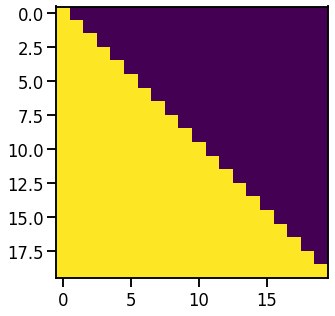

In [ ]:
# The attention mask shows the position each tgt word (row) is allowed to look at (column).
# Words are blocked for attending to future words during training. 
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])

## Scaled-Dot Product Attention:

An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors.  The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.                                                                                                                                                                                                                                            

We call our particular attention "Scaled Dot-Product Attention".   The input consists of queries and keys of dimension $d_k$, and values of dimension $d_v$.  We compute the dot products of the query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values.

<img width="220px" src="https://github.com/harvardnlp/annotated-transformer/blob/master/images/ModalNet-19.png?raw=true">

In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix $Q$.   The keys and values are also packed together into matrices $K$ and $V$.  We compute the matrix of outputs as:                      
                                                                 
$$                                                                         
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V               
$$ 

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

The two most commonly used attention functions are additive attention, and dot-product (multiplicative) attention.  Dot-product attention is identical to our algorithm, except for the scaling factor of $\frac{1}{\sqrt{d_k}}$. Additive attention computes the compatibility function using a feed-forward network with a single hidden layer.  While the two are similar in theoretical complexity, dot-product attention is much faster and more space-efficient in practice, since it can be implemented using highly optimized matrix multiplication code.                                                                                             

                                                                        
While for small values of $d_k$ the two mechanisms perform similarly, additive attention outperforms dot product attention without scaling for larger values of $d_k$. We suspect that for large values of $d_k$, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients  (To illustrate why the dot products get large, assume that the components of $q$ and $k$ are independent random variables with mean $0$ and variance $1$.  Then their dot product, $q \cdot k = \sum_{i=1}^{d_k} q_ik_i$, has mean $0$ and variance $d_k$.). To counteract this effect, we scale the dot products by $\frac{1}{\sqrt{d_k}}$.          

## Multi-Headed Attention:

Instead of performing a single attention function with $d_{\text{model}}$-dimensional keys, values and queries, we found it beneficial to linearly project the queries, keys and values $h$ times with different, learned linear projections to $d_k$, $d_k$ and $d_v$ dimensions, respectively.                                                                                                                                                                                                   
On each of these projected versions of queries, keys and values we then perform the attention function in parallel, yielding $d_v$-dimensional output values. These are concatenated and once again projected, resulting in the final values:

<img width="270px" src="https://github.com/harvardnlp/annotated-transformer/blob/master/images/ModalNet-20.png?raw=true">

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.                                                                                                                                                                                                                                                                                             
    
    
   
$$    
\mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O    \\                                           
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)                                
$$                                                                                                                                                                                                                                                                                                                                                                         
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
Where the projections are parameter matrices $W^Q_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in \mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in \mathbb{R}^{d_{\text{model}} \times d_v}$ and $W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}}$.                                                                                                                                                                                                                                                        
   

   
In this work we employ $h=8$ parallel attention layers, or heads. For each of these we use $d_k=d_v=d_{\text{model}}/h=64$. Due to the reduced dimension of each head, the total computational cost is similar to that of single-head attention with full dimensionality.  

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

## Position-wise Feed-Forward Networks 

In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically.  This consists of two linear transformations with a ReLU activation in between.

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$                                                                                                                                                                                                                                                         
                                                                                                                                                                                                                                                        
While the linear transformations are the same across different positions, they use different parameters from layer to layer. Another way of describing this is as two convolutions with kernel size 1.  The dimensionality of input and output is $d_{\text{model}}=512$, and the inner-layer has dimensionality $d_{ff}=2048$. 

In [ ]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))


## Embeddings

Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension $d_{\text{model}}$.  We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities.  In our model, we share the same weight matrix between the two embedding layers and the pre-softmax linear transformation. In the embedding layers, we multiply those weights by $\sqrt{d_{\text{model}}}$.  

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

## Positional Encoding

Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence.  To this end, we add "positional encodings" to the input embeddings at the bottoms of the encoder and decoder stacks.  The positional encodings have the same dimension $d_{\text{model}}$ as the embeddings, so that the two can be summed.   There are many choices of positional encodings, learned and fixed. 

In this work, we use sine and cosine functions of different frequencies:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
$$                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
    PE_{(pos,2i)} = sin(pos / 10000^{2i/d_{\text{model}}}) \\                                                                                                                                                                                                                                                                                                                                                                                                                                      
    PE_{(pos,2i+1)} = cos(pos / 10000^{2i/d_{\text{model}}})                                                                                                                                                                                                                                                                                                                                                                                                                                       
$$                                                                                                                                                                                                                                                        
where $pos$ is the position and $i$ is the dimension.  That is, each dimension of the positional encoding corresponds to a sinusoid.  The wavelengths form a geometric progression from $2\pi$ to $10000 \cdot 2\pi$.  We chose this function because we hypothesized it would allow the model to easily learn to attend by relative positions, since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a linear function of $PE_{pos}$. 

In addition, we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks.  For the base model, we use a rate of $P_{drop}=0.1$.

In [ ]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

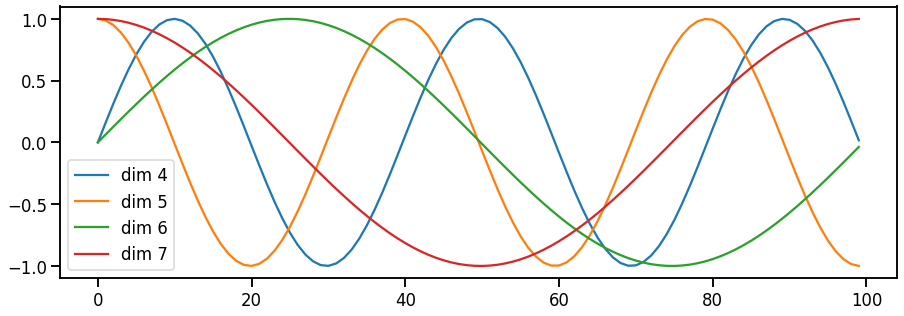

In [ ]:
# The positional encoding will add in a sine wave based on position.
# The frequency and offset of the wave is different for each dimension.
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
None

## Final Linear and Softmax Layer

In [ ]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

## Full Model

In [ ]:
def make_model(src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Construct a model object based on hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model, dropout)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. Initialize parameters with Glorot or fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [ ]:
# Small example model.
tmp_model = make_model(10, 10, 2)
tmp_model

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512)
            (1): Linear(in_features=512, out_features=512)
            (2): Linear(in_features=512, out_features=512)
            (3): Linear(in_features=512, out_features=512)
          )
          (dropout): Dropout(p=0.1)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048)
          (w_2): Linear(in_features=2048, out_features=512)
          (dropout): Dropout(p=0.1)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm(
            )
            (dropout): Dropout(p=0.1)
          )
          (1): SublayerConnection(
            (norm): LayerNorm(
            )
            (dropout): Dropout(p=0.1)
          )
        )
      )
      (1): Encod

# Training

## Optimizer

We used the Adam optimizer with $\beta_1=0.9$, $\beta_2=0.98$ and $\epsilon=10^{-9}$.  We varied the learning rate over the course of training, according to the formula:                                                                                            
$$                                                                                                                                                                                                                                                                                         
lrate = d_{\text{model}}^{-0.5} \cdot                                                                                                                                                                                                                                                                                                
  \min({step\_num}^{-0.5},                                                                                                                                                                                                                                                                                                  
    {step\_num} \cdot {warmup\_steps}^{-1.5})                                                                                                                                                                                                                                                                               
$$                                                                                                                                                                                             
This corresponds to increasing the learning rate linearly for the first $warmup\_steps$ training steps, and decreasing it thereafter proportionally to the inverse square root of the step number.  We used $warmup\_steps=4000$.

In [ ]:
# Note: This part is incredibly important. 
# Need to train with this setup of the model is very unstable.
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup**(-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

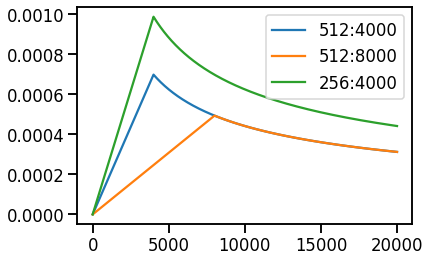

In [ ]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])

## Regularization

### Label Smoothing

During training, we employed label smoothing of value $\epsilon_{ls}=0.1$.  This hurts perplexity, as the model learns to be more unsure, but improves accuracy and BLEU score.

In [ ]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

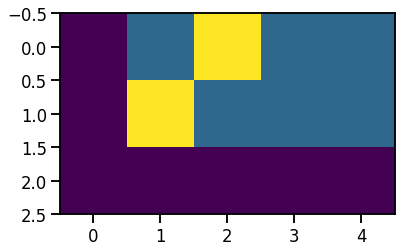

In [ ]:
#Example
crit = LabelSmoothing(5, 0, 0.5)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)

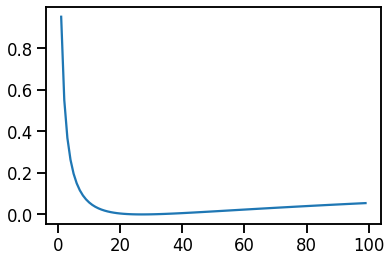

In [ ]:
# Label smoothing starts to penalize the model 
# if it gets very confident about a given choice
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    #print(predict)
    return crit(Variable(predict.log()),
                 Variable(torch.LongTensor([1]))).data[0]
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
None

## Batches and Masking

In [ ]:
class Batch:
    def __init__(self, src, trg, src_mask, trg_mask, ntokens):
        self.src = src
        self.trg = trg
        self.src_mask = src_mask
        self.trg_mask = trg_mask
        self.ntokens = ntokens
    
def make_std_mask(src, tgt, pad):
    src_mask = (src != pad).unsqueeze(-2)
    tgt_mask = (tgt != pad).unsqueeze(-2)
    tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
    return src_mask, tgt_mask

## Backpropagating Loop

In [ ]:
def loss_backprop(generator, criterion, out, targets, normalize, opt):
    """
    Memory optmization. Compute each timestep separately and sum grads.
    """
    assert out.size(1) == targets.size(1)
    total = 0.0
    out_grad = []
    for i in range(out.size(1)):
        out_column = Variable(out[:, i].data, requires_grad=True)
        gen = generator(out_column)
        loss = criterion(gen, targets[:, i]) / normalize
        total += loss.data[0]
        loss.backward()
        out_grad.append(out_column.grad.data.clone())
    out_grad = torch.stack(out_grad, dim=1)
    if opt is not None:
        out.backward(gradient=out_grad)
    return total

## Training Loop

In [ ]:
def train_epoch(train_iter, model, criterion, opt):
    model.train()
    for i, batch in enumerate(train_iter):
        src, trg, src_mask, trg_mask = batch.src, batch.trg, batch.src_mask, batch.trg_mask
        out = model.forward(src, trg[:, :-1], src_mask, trg_mask[:, :-1, :-1])
        loss = loss_backprop(model.generator, criterion, out, trg[:, 1:], batch.ntokens, opt)                         
        model_opt.step()
        model_opt.optimizer.zero_grad()
        if i % 100 == 0:
            print("Epoch Step: %d Loss: %f" % (i, loss / batch.ntokens, tokens / elapsed))

## Validation Loop

In [ ]:
def valid_epoch(valid_iter, model, criterion, opt=None):
    model.eval()
    total = 0
    total_tokens = 0
    for batch in valid_iter:
        src, trg, src_mask, trg_mask = batch.src, batch.trg, batch.src_mask, batch.trg_mask
        out = model.forward(src, trg[:, :-1], src_mask, trg_mask[:, :-1, :-1])
        loss = loss_backprop(model.generator, criterion, out, trg[:, 1:], batch.ntokens, opt)
        total_tokens += batch.ntokens
        total += loss
    print("Loss: %f" % (total/total_tokens))

# A Real World Example

Now we consider a real-world example using the IWSLT German-English Translation task. This task is much smaller than the WMT task considered in the paper, but it illustrates the whole system. We also show how to use multi-gpu processing to make it really fast.

In [ ]:
!pip install torchtext spacy
!python -m spacy download en
!python -m spacy download de

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')
     |████████████████████████████████| 14.9MB 617kB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp36-none-any.whl size=14907056 sha256=2f7aac85fdd29ec85c4479a3c4e57c62be81a061e98f4b72f32ba1d7e7e70fcd
  Stored in directory: /tmp/pip-ephem-wheel-cache-6lj5gqd9/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')


## Data Loading

In [ ]:
# For data loading.
from torchtext import data, datasets

if True:
    import spacy
    spacy_de = spacy.load('de')
    spacy_en = spacy.load('en')

    def tokenize_de(text):
        return [tok.text for tok in spacy_de.tokenizer(text)]

    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]

    BOS_WORD = '<s>'
    EOS_WORD = '</s>'
    BLANK_WORD = "<blank>"
    SRC = data.Field(tokenize=tokenize_de, pad_token=BLANK_WORD)
    TGT = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, 
                     eos_token = EOS_WORD, pad_token=BLANK_WORD)

    MAX_LEN = 100
    train, val, test = datasets.IWSLT.splits(
        exts=('.de', '.en'), fields=(SRC, TGT), 
        filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
            len(vars(x)['trg']) <= MAX_LEN)
    MIN_FREQ = 2
    SRC.build_vocab(train.src, min_freq=MIN_FREQ)
    TGT.build_vocab(train.trg, min_freq=MIN_FREQ)

downloading de-en.tgz
.data/iwslt/de-en/IWSLT16.TED.dev2010.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2013.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2013.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.dev2010.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2013.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2014.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2013.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2011.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2014.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TEDX.dev2012.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2011.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2010.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2014.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TEDX.dev2012.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2010.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TED.tst2012.de-en.de.xml
.data/iwslt/de-en/IWSLT16.TEDX.tst2014.de-en.en.xml
.data/iwslt/de-en/IWSLT16.TED.tst2012.de-en.en.xml
.data/iwslt/de-en/train.tags.de-en.en
.data/iwslt/de-e

Batching matters a ton for speed. We want to have very evenly divided batches, with absolutely minimal padding.

## Batches and Iterators

In [ ]:
BATCH_SIZE = 4096
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    src_mask, trg_mask = make_std_mask(src, trg, pad_idx)
    return Batch(src, trg, src_mask, trg_mask, (trg[1:] != pad_idx).data.sum())

train_iter = MyIterator(train, batch_size=BATCH_SIZE, device=0,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=True)
valid_iter = MyIterator(val, batch_size=BATCH_SIZE, device=0,
                        repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                        batch_size_fn=batch_size_fn, train=False)

## Greedy Decoding

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

## Training the System

Load pretrained model

In [ ]:
!wget https://s3.amazonaws.com/opennmt-models/en-de-model.pt

--2020-08-14 09:53:14--  https://s3.amazonaws.com/opennmt-models/en-de-model.pt
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.146.237
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.146.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 393031182 (375M) [application/x-www-form-urlencoded]
Saving to: ‘en-de-model.pt’

en-de-model.pt      100%[===================>] 374.82M  35.8MB/s    in 11s     

2020-08-14 09:53:26 (33.6 MB/s) - ‘en-de-model.pt’ saved [393031182/393031182]



or 

Train the model

In [ ]:
num_epochs = 20
train = False

if train:
    pad_idx = TGT.vocab.stoi["<blank>"]
    model = make_model(len(SRC.vocab), len(TGT.vocab), N=6)
    model_opt = get_std_opt(model)
    model.cuda()
    criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
    criterion.cuda()
    for epoch in range(num_epochs):
        train_epoch((rebatch(pad_idx, b) for b in train_iter), model, criterion, model_opt)
        valid_epoch((rebatch(pad_idx, b) for b in valid_iter), model, criterion)
else:
    model, SRC, TGT = torch.load("en-de-model.pt")

Once trained we can decode the model to produce a set of translations. Here we simply translate the given sentence from the dataset. This dataset is pretty small so the translations with greedy search are reasonably accurate.

In [ ]:
sentence = "▁The ▁log ▁file ▁can ▁be ▁sent ▁with ▁email ▁or ▁FTP ▁to ▁a ▁specified ▁receiver"
model.eval()
sent = sentence.split()
src = torch.LongTensor([[SRC.stoi[w] for w in sent]])
src = Variable(src)
src_mask = (src != SRC.stoi["<blank>"]).unsqueeze(-2)
out = greedy_decode(model, src, src_mask, 
                    max_len=60, start_symbol=TGT.stoi["<s>"])
print("Translation:", end="\t")
trans = "<s> "
for i in range(1, out.size(1)):
    sym = TGT.itos[out[0, i]]
    if sym == "</s>": break
    trans += sym + " "
print(trans)

Translation:	<s> ▁Die ▁Protokoll datei ▁kann ▁per ▁E - Mail ▁oder ▁FTP ▁an ▁einen ▁bestimmte n ▁Empfänger ▁gesendet ▁werden . 
